
Univariate analysis of block design, one condition versus rest, single subject
==============================================================================

Authors: Bertrand Thirion, Elvis Dohmatob , Christophe Pallier, 2015--2017
Modified: Ralf Schmaelzle, 2019

In this tutorial, we compare the fMRI signal during periods of auditory stimulation
versus periods of rest, using a General Linear Model (GLM). We will
use a univariate approach in which independent tests are performed at
each single-voxel.

The dataset comes from experiment conducted at the FIL by Geriant Rees
under the direction of Karl Friston. It is provided by FIL methods
group which develops the SPM software.

According to SPM documentation, 96 acquisitions were made (RT=7s), in
blocks of 6, giving 16 42s blocks. The condition for successive blocks
alternated between rest and auditory stimulation, starting with rest.
Auditory stimulation was bi-syllabic words presented binaurally at a
rate of 60 per minute. The functional data starts at acquisiton 4,
image fM00223_004.

The whole brain BOLD/EPI images were acquired on a modified 2T Siemens
MAGNETOM Vision system. Each acquisition consisted of 64 contiguous
slices (64x64x64 3mm x 3mm x 3mm voxels). Acquisition took 6.05s, with
the scan to scan repeat time (RT) set arbitrarily to 7s.


This analyse described here is performed in the native space, on the
original EPI scans without any spatial or temporal preprocessing.
(More sensitive results would likely be obtained on the corrected,
spatially normalized and smoothed images).

## Import modules

In [1]:
import os, sys, nibabel
!pip install nistats
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from os.path import join
import seaborn as sns

from nilearn import plotting, datasets, image     
from nilearn.image import concat_imgs
from nilearn.input_data import NiftiSpheresMasker
from nistats.first_level_model import FirstLevelModel
from nistats.datasets import fetch_spm_auditory
from nistats.reporting import plot_design_matrix
from nilearn.plotting import plot_stat_map, plot_anat, plot_img

from nibabel.affines import apply_affine

/Users/Ralf/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)
/Users/Ralf/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: DeprecationWarning: Python2 support is deprecated and will be removed in a future release. Consider switching to Python3.
  del sys.path[0]


Retrieving the data
-------------------

We can list the filenames of the functional images


In [2]:
subject_data = fetch_spm_auditory()
subject_data

{'func': ['/Users/Ralf/nilearn_data/spm_auditory/sub001/fM00223/fM00223_004.img',
  '/Users/Ralf/nilearn_data/spm_auditory/sub001/fM00223/fM00223_005.img',
  '/Users/Ralf/nilearn_data/spm_auditory/sub001/fM00223/fM00223_006.img',
  '/Users/Ralf/nilearn_data/spm_auditory/sub001/fM00223/fM00223_007.img',
  '/Users/Ralf/nilearn_data/spm_auditory/sub001/fM00223/fM00223_008.img',
  '/Users/Ralf/nilearn_data/spm_auditory/sub001/fM00223/fM00223_009.img',
  '/Users/Ralf/nilearn_data/spm_auditory/sub001/fM00223/fM00223_010.img',
  '/Users/Ralf/nilearn_data/spm_auditory/sub001/fM00223/fM00223_011.img',
  '/Users/Ralf/nilearn_data/spm_auditory/sub001/fM00223/fM00223_012.img',
  '/Users/Ralf/nilearn_data/spm_auditory/sub001/fM00223/fM00223_013.img',
  '/Users/Ralf/nilearn_data/spm_auditory/sub001/fM00223/fM00223_014.img',
  '/Users/Ralf/nilearn_data/spm_auditory/sub001/fM00223/fM00223_015.img',
  '/Users/Ralf/nilearn_data/spm_auditory/sub001/fM00223/fM00223_016.img',
  '/Users/Ralf/nilearn_data/sp

Display the first functional image:

RalfNote: there will be some ugly red error code. Just re-run the cell again and it should be gone


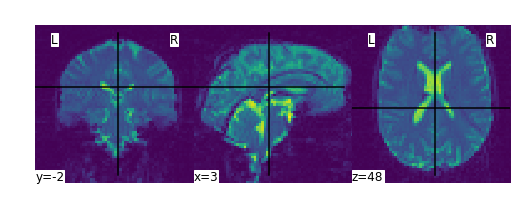

In [3]:
%matplotlib inline
plot_img(subject_data.func[0]);

Display the subject's anatomical image:



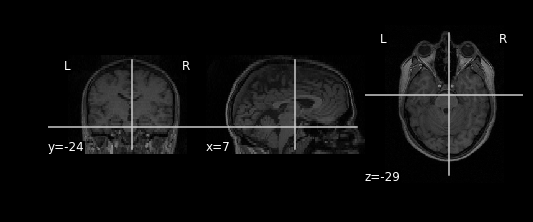

In [4]:
plot_anat(subject_data.anat);
#plotting.view_img(subject_data.anat)  

Next, we concatenate all the 3D EPI image into a single 4D image.

In [5]:
fmri_img = concat_imgs(subject_data.func)
print(fmri_img.shape)

(64, 64, 64, 96)


plot data from one voxel

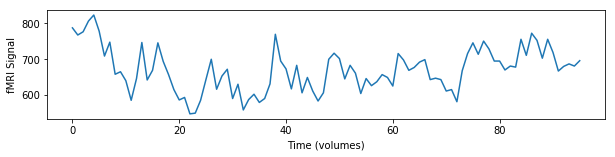

In [6]:
data_from_one_voxel = fmri_img.get_data()[22,30,26,:] #22,30,26
plt.figure(figsize = (10,2))
plt.plot(data_from_one_voxel);
plt.xlabel('Time (volumes)');
plt.ylabel('fMRI Signal');

And we average all the EPI images in order to create a background image that will be used to display the activations:

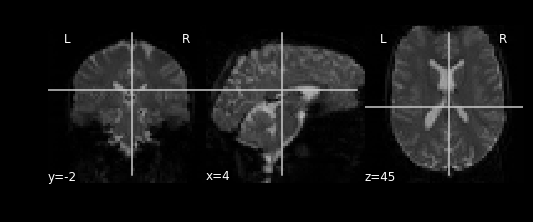

In [7]:
mean_img = image.mean_img(fmri_img)
plot_anat(mean_img);

Specifying the experimental paradigm
------------------------------------

We must provide a description of the experiment, that is, define the
timing of the auditory stimulation and rest periods. According to
the documentation of the dataset, there were 16 42s blocks --- in
which 6 scans were acquired --- alternating between rest and
auditory stimulation, starting with rest. We use standard python
functions to create a pandas.DataFrame object that specifies the
timings:



In [8]:
tr = 7.
slice_time_ref = 0.
n_scans = 96
epoch_duration = 6 * tr  # duration in seconds
conditions = ['rest', 'active'] * 8
n_blocks = len(conditions)
duration = epoch_duration * np.ones(n_blocks)
onset = np.linspace(0, (n_blocks - 1) * epoch_duration, n_blocks)

events = pd.DataFrame({'onset': onset, 'duration': duration, 'trial_type': conditions})

The ``events`` object contains the information for the design:



In [9]:
print(events)

    onset  duration trial_type
0     0.0      42.0       rest
1    42.0      42.0     active
2    84.0      42.0       rest
3   126.0      42.0     active
4   168.0      42.0       rest
5   210.0      42.0     active
6   252.0      42.0       rest
7   294.0      42.0     active
8   336.0      42.0       rest
9   378.0      42.0     active
10  420.0      42.0       rest
11  462.0      42.0     active
12  504.0      42.0       rest
13  546.0      42.0     active
14  588.0      42.0       rest
15  630.0      42.0     active


Performing the GLM analysis
---------------------------

We need to construct a *design matrix* using the timing information
provided by the ``events`` object. The design matrix contains
regressors of interest as well as regressors of non-interest
modeling temporal drifts:



In [10]:
frame_times = np.linspace(0, (n_scans - 1) * tr, n_scans)
drift_model = 'Cosine'
period_cut = 4. * epoch_duration
hrf_model = 'glover + derivative'

It is now time to create a ``FirstLevelModel`` object
and fit it to the 4D dataset:



In [11]:
fmri_glm = FirstLevelModel(tr, slice_time_ref, noise_model='ar1',
                           standardize=False, hrf_model=hrf_model,
                           drift_model=drift_model, period_cut=period_cut)
fmri_glm = fmri_glm.fit(fmri_img, events)

/Users/Ralf/.local/lib/python3.6/site-packages/scipy/linalg/basic.py:1226: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  warnings.warn(mesg, RuntimeWarning)


One can inspect the design matrix (rows represent time, and
columns contain the predictors):



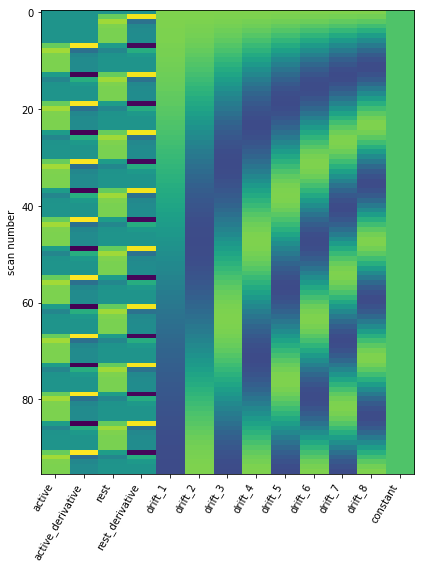

In [12]:
design_matrix = fmri_glm.design_matrices_[0]
fig, ax1 = plt.subplots(figsize=(6, 8), nrows=1, ncols=1)
plot_design_matrix(design_matrix, ax= ax1, rescale= True);

The first column contains the expected reponse profile of regions which are
sensitive to the auditory stimulation.



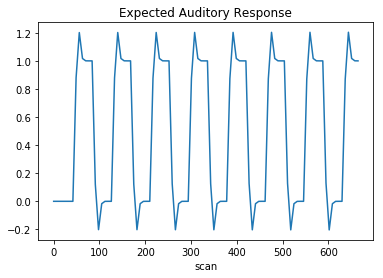

In [13]:
plt.plot(design_matrix['active'])
plt.xlabel('scan')
plt.title('Expected Auditory Response')
plt.show()

Detecting voxels with significant effects
-----------------------------------------

To access the estimated coefficients (Betas of the GLM model), we
created constrasts with a single '1' in each of the columns:



In [14]:
contrast_matrix = np.eye(design_matrix.shape[1])
contrasts = dict([(column, contrast_matrix[i])
                  for i, column in enumerate(design_matrix.columns)])

"""
contrasts::

  {
  'active':            array([ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]),
  'active_derivative': array([ 0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]),
  'constant':          array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.]),
  'drift_1':           array([ 0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]),
  'drift_2':           array([ 0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.]),
  'drift_3':           array([ 0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.]),
  'drift_4':           array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.]),
  'drift_5':           array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.]),
  'drift_6':           array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.]),
  'drift_7':           array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.]),
  'rest':              array([ 0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]),
  'rest_derivative':   array([ 0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.])}
"""

"\ncontrasts::\n\n  {\n  'active':            array([ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]),\n  'active_derivative': array([ 0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]),\n  'constant':          array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.]),\n  'drift_1':           array([ 0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]),\n  'drift_2':           array([ 0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.]),\n  'drift_3':           array([ 0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.]),\n  'drift_4':           array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.]),\n  'drift_5':           array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.]),\n  'drift_6':           array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.]),\n  'drift_7':           array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.]),\n  'rest':              array([ 0.,  0.,  1.,  0

We can then compare the two conditions 'active' and 'rest' by
generating the relevant contrast:



In [15]:
active_minus_rest =  contrasts['active'] - contrasts['rest']

eff_map = fmri_glm.compute_contrast(active_minus_rest,
                                    output_type='effect_size')

z_map = fmri_glm.compute_contrast(active_minus_rest,
                                  output_type='z_score')

Plot thresholded z scores map



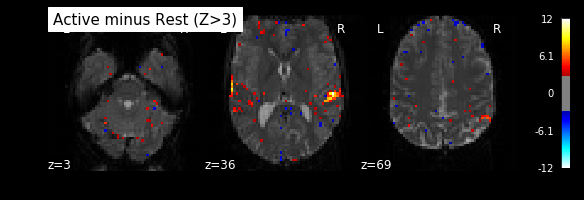

In [16]:
plot_stat_map(z_map, bg_img=mean_img, threshold=3.0,
              display_mode='z', cut_coords=3, black_bg=True,
              title='Active minus Rest (Z>3)');

In [17]:
plotting.view_img(z_map, bg_img=mean_img, threshold=3., title="Active vs. Rest contrast")  

We can use ``nibabel.save`` to save the effect and zscore maps to the disk



In [ ]:
outdir = 'results'
if not os.path.exists(outdir):
    os.mkdir(outdir)

nibabel.save(z_map, join('results', 'active_vs_rest_z_map.nii'))
nibabel.save(eff_map, join('results', 'active_vs_rest_eff_map.nii'))

Extract the signal from a voxels
 --------------------------------

We search for the voxel with the larger z-score and plot the signal
(warning: double dipping!)



In [18]:
# Find the coordinates of the peak


values = z_map.get_data()
coord_peaks = np.dstack(np.unravel_index(np.argsort(values.ravel()),
                                         values.shape))[0, 0, :]
coord_mm = apply_affine(z_map.affine, coord_peaks)

We create a masker for the voxel (allowing us to detrend the signal)
and extract the time course



In [19]:
mask = NiftiSpheresMasker([coord_mm], radius=3,
                          detrend=True, standardize=True,
                          high_pass=None, low_pass=None, t_r=7.)
sig = mask.fit_transform(fmri_img)

Let's plot the signal and the theoretical response



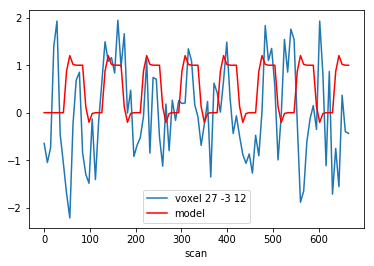

In [20]:
plt.plot(frame_times, sig, label='voxel %d %d %d' % tuple(coord_mm))
plt.plot(design_matrix['active'], color='red', label='model')
plt.xlabel('scan')
plt.legend()
plt.show()

0.12667153070648837

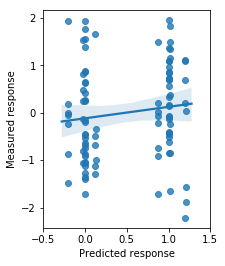

In [22]:
plt.figure(figsize = (3,4));
sns.regplot(design_matrix['active'], np.squeeze(sig));
plt.xlim([-0.5, 1.5]);
plt.xlabel('Predicted response')
plt.ylabel('Measured response')
#plt.axis('equal')
np.corrcoef(np.squeeze(sig),design_matrix['active'] )[0,1]